In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
pip install chardet

In [3]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os

In [4]:
# Load tokenizer and pre-trained model
tokenizer = AutoTokenizer.from_pretrained("lakshyakh93/deberta_finetuned_pii")
model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.31k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/555M [00:00<?, ?B/s]

In [17]:
# Load the mini dataset (200 row)
import chardet

filepath = os.path.join(os.getcwd(), 'mini_df_200_row_biolabels.csv')

# Detect encoding
with open(filepath, 'rb') as f:
    result = chardet.detect(f.read())
    print("Detected file encoding:", result['encoding'])

# Read the file using the detected encoding
mini_df = pd.read_csv(filepath, encoding=result['encoding'])

# Proportional split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Since you have 200 rows, no need for the 3,000 cap, as this won't be needed
train_size = int(len(mini_df) * train_ratio)
val_size = int(len(mini_df) * val_ratio)
test_size = len(mini_df) - train_size - val_size  # Remaining rows for the test set

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(mini_df, test_size=1 - train_ratio, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

# Print dataset sizes to confirm
print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Detected file encoding: Windows-1252
Training size: 134
Validation size: 29
Test size: 29


In [23]:
# For the cleaned mini dataframe
# Create a mapping for the bio_labels
data_label_list = []

# Extract unique labels from the 'bio_labels' column
def get_unique_labels(df):
    unique_labels = set()
    for labels in df['bio_labels']:  # Iterate through the 'bio_labels' column
        # Since bio_labels is a string representation of a list, we need to convert it back to a list
        labels = eval(labels)  # Convert the string to a list
        unique_labels.update(labels)  # Add all labels in the current row to the set
    return sorted(unique_labels)  # Return sorted labels for consistency

# Apply the function to the entire DataFrame
unique_labels = get_unique_labels(mini_df)  # Run on the whole DataFrame

# Print the unique labels
print("Data's Unique BIO Labels:", unique_labels)

# Combine with the existing label_list (if applicable)
data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
print("Data's Final Label List:", data_label_list)
print(len(data_label_list))  # Number of unique labels

data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

TypeError: eval() arg 1 must be a string, bytes or code object

In [123]:
# Load pii-200k dataset
dataset = load_dataset("Isotonic/pii-masking-200k")

# Shuffle the dataset
shuffled_dataset = dataset["train"].shuffle(seed=42)

# Select the first 300 rows as the test dataset
pii200k_dataset = shuffled_dataset.select(range(5000))

# Print some test data (optional)
print(pii200k_dataset[:10])
print(f"Test size: {len(pii200k_dataset)}")

{'masked_text': ["Les parents sont autorisés à effectuer les paiements pour les fournitures d'art en [CURRENCYNAME_1] sur le compte avec l'IBAN [IBAN_1].", '[FIRSTNAME_1], regarding our discussion on trade laws, the [CREDITCARDNUMBER_1] card ending with [MASKEDNUMBER_1] will be charged [AMOUNT_1][CURRENCYSYMBOL_1]', 'Riguardo alla rappresentazione di [FIRSTNAME_1]. Problema legale con [COMPANYNAME_1]. Link per la riunione inviato a [EMAIL_1].', 'Your [CREDITCARDNUMBER_1] got billed with [CURRENCYSYMBOL_1][MASKEDNUMBER_1] for attending the Time Management Masterclass.', '[FIRSTNAME_1] lebt in [BUILDINGNUMBER_1] [STREET_1] [SECONDARYADDRESS_1] in [CITY_1] in [STATE_1]. Die nächstgelegene GPS-Koordinate zu ihrem Wohnort ist [NEARBYGPSCOORDINATE_1].', "Un bâtiment avec le numéro [BUILDINGNUMBER_1] sur [STREET_1] a signalé une violation des lois d'aménagement. Veuillez y remédier dès que possible.", 'Veuillez confirmer que le coût de votre dernier service de santé était de [CURRENCY_1] [AMO

In [124]:
# Convert test_dataset into a dataframe
pii200k_df = pii200k_dataset.to_pandas()
eng_df = pii200k_df[pii200k_df['language'] == 'en']
print(len(eng_df))

1035


In [125]:
# Filter rows where 'bio_labels' is not null (though unlikely given your data)
valid_eng_df = eng_df[eng_df['bio_labels'].notnull()]

import numpy as np
import re

def clean_bio_labels(bio_labels):
    # Flatten the numpy array of bio_labels and remove any non-printable characters
    bio_labels = [label for label in bio_labels.flatten() if isinstance(label, str)]
    cleaned_labels = [re.sub(r'[^\x20-\x7E]', '', label) for label in bio_labels]
    return cleaned_labels

# Apply the cleaning function to each bio_labels entry
valid_eng_df['bio_labels'] = valid_eng_df['bio_labels'].apply(clean_bio_labels)

# Check the cleaned bio_labels
print(f"Cleaned bio_labels: {valid_eng_df['bio_labels'].head()}")

# Check the resulting DataFrame
print(f"Number of valid rows: {len(valid_eng_df)}")

Cleaned bio_labels: 1     [B-FIRSTNAME, O, O, O, O, O, O, O, O, O, B-CRE...
3     [O, B-CREDITCARDNUMBER, I-CREDITCARDNUMBER, I-...
13    [O, O, O, O, O, O, O, O, B-COUNTY, I-COUNTY, O...
14    [O, B-MIDDLENAME, O, O, O, O, O, O, O, O, O, B...
21    [B-FIRSTNAME, O, O, O, O, O, O, O, O, O, O, O,...
Name: bio_labels, dtype: object
Number of valid rows: 1035


In [126]:
data_label_list = []

# Extract unique BIO labels
unique_labels = set()

# Iterate through the 'bio_labels' column
for labels in valid_eng_df['bio_labels']:
    unique_labels.update(labels)  # Add all unique labels from each array

# Convert to sorted list for consistency
unique_labels = sorted(unique_labels)

print("Data's Unique BIO Labels:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Combine with the existing label_list (if applicable)
data_label_list = sorted(set(data_label_list + unique_labels))  # Ensure no duplicates
print("Data's Final Label List:", data_label_list)
print(len(data_label_list))  # Number of unique labels

data_label_to_id = {label: idx for idx, label in enumerate(data_label_list)}
data_id_to_label = {idx: label for label, idx in data_label_to_id.items()}

Data's Unique BIO Labels: ['B-ACCOUNTNAME', 'B-ACCOUNTNUMBER', 'B-AGE', 'B-AMOUNT', 'B-BIC', 'B-BITCOINADDRESS', 'B-BUILDINGNUMBER', 'B-CITY', 'B-COMPANYNAME', 'B-COUNTY', 'B-CREDITCARDCVV', 'B-CREDITCARDISSUER', 'B-CREDITCARDNUMBER', 'B-CURRENCY', 'B-CURRENCYCODE', 'B-CURRENCYNAME', 'B-CURRENCYSYMBOL', 'B-DATE', 'B-DOB', 'B-EMAIL', 'B-ETHEREUMADDRESS', 'B-EYECOLOR', 'B-FIRSTNAME', 'B-GENDER', 'B-HEIGHT', 'B-IBAN', 'B-IP', 'B-IPV4', 'B-IPV6', 'B-JOBAREA', 'B-JOBTITLE', 'B-JOBTYPE', 'B-LASTNAME', 'B-LITECOINADDRESS', 'B-MAC', 'B-MASKEDNUMBER', 'B-MIDDLENAME', 'B-NEARBYGPSCOORDINATE', 'B-ORDINALDIRECTION', 'B-PASSWORD', 'B-PHONEIMEI', 'B-PHONENUMBER', 'B-PIN', 'B-PREFIX', 'B-SECONDARYADDRESS', 'B-SEX', 'B-SSN', 'B-STATE', 'B-STREET', 'B-TIME', 'B-URL', 'B-USERAGENT', 'B-USERNAME', 'B-VEHICLEVIN', 'B-VEHICLEVRM', 'B-ZIPCODE', 'I-ACCOUNTNAME', 'I-ACCOUNTNUMBER', 'I-AGE', 'I-AMOUNT', 'I-BIC', 'I-BITCOINADDRESS', 'I-BUILDINGNUMBER', 'I-CITY', 'I-COMPANYNAME', 'I-COUNTY', 'I-CREDITCARDCVV', '

In [127]:
model_label_list = model.config.id2label.values()  # Ensure this matches the fine-tuned model
model_id_to_label = {int(k): v for k, v in model.config.id2label.items()}
model_label_to_id = {v: int(k) for k, v in model_id_to_label.items()}

print("Model's Label to ID:", model_label_to_id)
print("Model's ID to Label:", model_id_to_label)
print(len(model_label_list))

Model's Label to ID: {'B-PREFIX': 0, 'I-PREFIX': 1, 'B-FIRSTNAME': 2, 'I-FIRSTNAME': 3, 'B-MIDDLENAME': 4, 'B-LASTNAME': 5, 'I-LASTNAME': 6, 'O': 7, 'B-JOBDESCRIPTOR': 8, 'B-JOBTITLE': 9, 'I-JOBTITLE': 10, 'B-COMPANY_NAME': 11, 'I-COMPANY_NAME': 12, 'B-JOBAREA': 13, 'B-EMAIL': 14, 'I-EMAIL': 15, 'B-TIME': 16, 'I-TIME': 17, 'B-DATE': 18, 'I-DATE': 19, 'B-URL': 20, 'I-URL': 21, 'B-BITCOINADDRESS': 22, 'I-BITCOINADDRESS': 23, 'B-ETHEREUMADDRESS': 24, 'I-ETHEREUMADDRESS': 25, 'B-ACCOUNTNAME': 26, 'I-ACCOUNTNAME': 27, 'B-IBAN': 28, 'I-IBAN': 29, 'B-ACCOUNTNUMBER': 30, 'I-ACCOUNTNUMBER': 31, 'B-BIC': 32, 'I-BIC': 33, 'B-IPV4': 34, 'I-IPV4': 35, 'B-STREETADDRESS': 36, 'I-STREETADDRESS': 37, 'B-CITY': 38, 'I-CITY': 39, 'B-ZIPCODE': 40, 'I-ZIPCODE': 41, 'B-USERNAME': 42, 'I-USERNAME': 43, 'B-IPV6': 44, 'I-IPV6': 45, 'B-CREDITCARDNUMBER': 46, 'I-CREDITCARDNUMBER': 47, 'B-VEHICLEVIN': 48, 'I-VEHICLEVIN': 49, 'B-SUFFIX': 50, 'I-SUFFIX': 51, 'B-AMOUNT': 52, 'I-AMOUNT': 53, 'B-CURRENCY': 54, 'I-CURR

In [128]:
# Define metrics calculation function
def compute_metrics(predictions, references):
    acc = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average="weighted", zero_division=1)
    recall = recall_score(references, predictions, average="weighted", zero_division=1)
    f1 = f1_score(references, predictions, average="weighted", zero_division=1)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [129]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import numpy as np

# Prepare data for tokenization and create a PyTorch Dataset
def tokenize_and_align_labels(df, tokenizer, data_label_to_id, model_label_to_id):
    def normalize_label(label):
        # Remove suffixes like "_1", "_2"
        if "_" in label and label.split("_")[-1].isdigit():
            return "_".join(label.split("_")[:-1])
        return label

    def map_labels_to_model(data_label):
        normalized_label = normalize_label(data_label)  # Normalize dataset labels
        return model_label_to_id.get(normalized_label, model_label_to_id.get("O", -100))  # Default to "O"

    tokenized_inputs = tokenizer(
        list(valid_eng_df["unmasked_text"]),  # Convert Series to list of strings
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
        is_split_into_words=False,
    )

    labels = []
    for i, label_seq in enumerate(valid_eng_df["bio_labels"]):
        # word_labels = eval(label_seq)  # Convert string back to Python list
        word_labels = label_seq  # Directly use the list of labels
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens back to words
        token_labels = []
        for word_id in word_ids:
            if word_id is None:  # Special tokens
                token_labels.append(-100)
            elif word_id < len(word_labels):  # Ensure within bounds
                token_labels.append(map_labels_to_model(word_labels[word_id]))
            else:
                token_labels.append(-100)  # Ignore out-of-bounds tokens
        labels.append(token_labels)

    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Tokenize the test set
tokenized_test = tokenize_and_align_labels(valid_eng_df, tokenizer, data_label_to_id, model_label_to_id)

# Create a DataLoader for the test set
test_dataset = torch.utils.data.TensorDataset(tokenized_test["input_ids"], tokenized_test["attention_mask"], tokenized_test["labels"])

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [130]:
for key, value in tokenized_test.items():
    print(f"{key}: {value.shape}")

input_ids: torch.Size([1035, 137])
token_type_ids: torch.Size([1035, 137])
attention_mask: torch.Size([1035, 137])
labels: torch.Size([1035, 137])


In [131]:
id_to_label = {v: k for k, v in model_label_to_id.items()}

In [132]:
# Inference loop
all_predictions, all_references = [], []
model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        # Align predictions and references to only include non-special tokens
        for pred, label in zip(predictions, labels):
            true_labels = [
                id_to_label[l] for l in label if l != -100
            ]  # Convert ground truth IDs to labels
            pred_labels = [
                id_to_label.get(p, "O") for p, l in zip(pred, label) if l != -100
            ]  # Convert predictions to labels, defaulting to "O" for unmapped IDs

            all_predictions.extend(pred_labels)
            all_references.extend(true_labels)

# Calculate metrics
metrics = compute_metrics(all_predictions, all_references)
print("Metrics:", metrics)

Metrics: {'accuracy': 0.6074997827409403, 'precision': 0.6647632196767436, 'recall': 0.6074997827409403, 'f1': 0.6232164342384321}


In [102]:
print(f"all predictions: {all_predictions}")
print(f"number of all predictions: {len(all_predictions)}")
print(f"all references: {all_references}")
print(f"number of all references: {len(all_references)}")

all predictions: ['B-FIRSTNAME', 'B-FIRSTNAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ACCOUNTNUMBER', 'B-ACCOUNTNUMBER', 'B-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'O', 'O', 'O', 'B-ACCOUNTNUMBER', 'B-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'O', 'O', 'O', 'B-AMOUNT', 'B-AMOUNT', 'I-AMOUNT', 'I-AMOUNT', 'I-AMOUNT', 'I-AMOUNT', 'I-AMOUNT', 'B-CURRENCYSYMBOL', 'B-CURRENCYSYMBOL', 'I-CURRENCYSYMBOL', 'O', 'B-ACCOUNTNUMBER', 'B-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'I-ACCOUNTNUMBER', 'O', 'O', 'O', 'B-CURRENCYSYMBOL', 'B-CURRENCYSYMBOL', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'I-MASKEDNUMBER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CITY', 'B-CITY', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-D

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Extract the unique classes from all_references and all_predictions
unique_labels = sorted(set(all_references) | set(all_predictions))
display_labels = [id_to_label[label] for label in unique_labels]

# Plot the confusion matrix with consistent labels
ConfusionMatrixDisplay.from_predictions(
    all_references,
    all_predictions,
    display_labels=display_labels
)
plt.title("Confusion Matrix (Filtered Labels)")
plt.show()

KeyError: 'B-ACCOUNTNAME'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

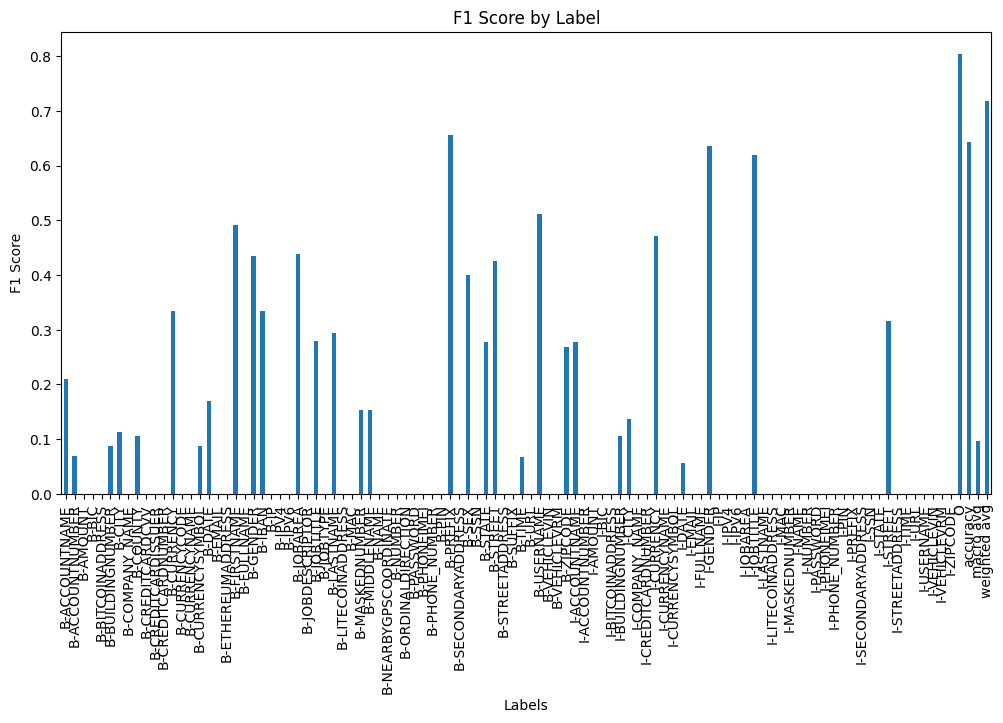

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(all_references, all_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot F1 scores for each label
df["f1-score"].plot(kind="bar", figsize=(12, 6))
plt.title("F1 Score by Label")
plt.ylabel("F1 Score")
plt.xlabel("Labels")
plt.show()

True: I-CURRENCYCODE, Predicted: I-CURRENCYCODE, Count: 3731
True: I-CURRENCYCODE, Predicted: I-CREDITCARDISSUER, Count: 182
True: I-CURRENCYCODE, Predicted: B-CURRENCYNAME, Count: 125
True: I-CURRENCYCODE, Predicted: I-ZIPCODE, Count: 78
True: I-CURRENCYCODE, Predicted: I-BUILDINGNUMBER, Count: 69
True: I-CURRENCYCODE, Predicted: B-PHONEIMEI, Count: 59
True: I-DATE, Predicted: I-DATE, Count: 53
True: I-CURRENCYCODE, Predicted: I-STREET, Count: 50
True: I-CURRENCYCODE, Predicted: I-MIDDLENAME, Count: 46
True: I-CURRENCYCODE, Predicted: I-USERAGENT, Count: 42


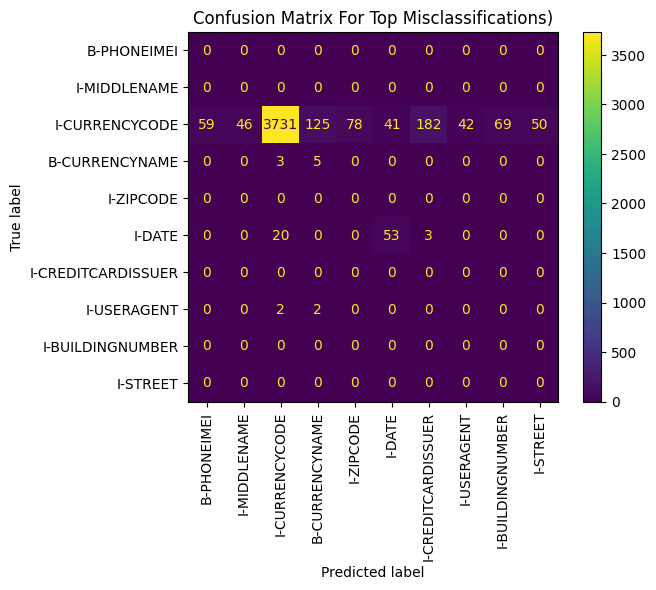

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np

cm = confusion_matrix(all_references, all_predictions)
misclassified_indices = np.unravel_index(np.argsort(-cm, axis=None), cm.shape)
top_misclassifications = [
    (id_to_label[misclassified_indices[0][i]], id_to_label[misclassified_indices[1][i]], cm[misclassified_indices[0][i], misclassified_indices[1][i]])
    for i in range(10)  # Top 10 misclassifications
]

for true, predicted, count in top_misclassifications:
    print(f"True: {true}, Predicted: {predicted}, Count: {count}")

# Extract unique indices for the top misclassifications
unique_indices = list(set([misclassified_indices[0][i] for i in range(10)] +
                          [misclassified_indices[1][i] for i in range(10)]))

# Create a subset confusion matrix
subset_cm = cm[np.ix_(unique_indices, unique_indices)]
subset_labels = [list(id_to_label.values())[i] for i in unique_indices]

# Plot the subset confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=subset_cm, display_labels=subset_labels)
disp.plot(cmap="viridis", xticks_rotation="vertical", colorbar=True)
plt.title("Confusion Matrix For Top Misclassifications)")
plt.show()

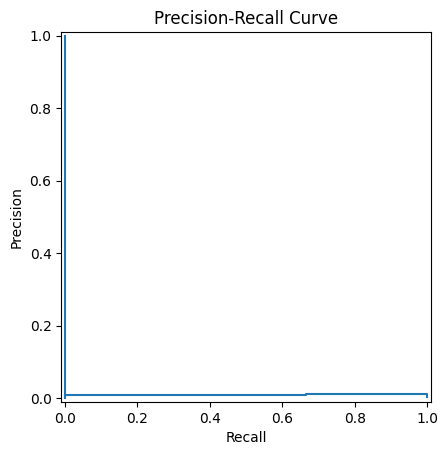

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


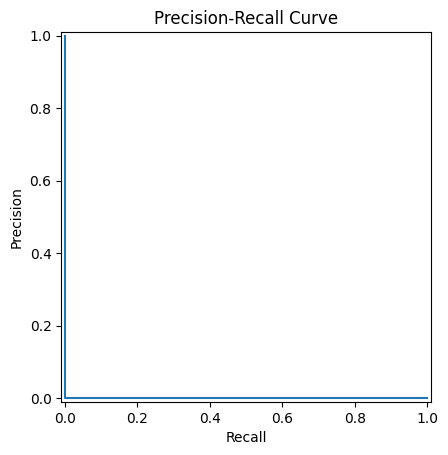

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Convert string labels to numeric IDs using id_to_label reverse mapping
label_to_id_reverse = {label: idx for idx, label in id_to_label.items()}

# Map predictions and references to numeric IDs
numeric_predictions = [label_to_id_reverse[label] for label in all_predictions]
numeric_references = [label_to_id_reverse[label] for label in all_references]

# Choose the label ID of interest (e.g., for binary classification, the positive class)
pos_label_id = label_to_id_reverse["B-CREDITCARDNUMBER"]  # Replace "B-YOUR_LABEL" with your target class

# Compute precision-recall curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label=pos_label_id)

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# Flatten predictions and references for multiclass handling (if applicable)
# Note: This works best for binary or one-vs-all analysis.
# Example below assumes binary or flattened labels.
precision, recall, _ = precision_recall_curve(numeric_references, numeric_predictions, pos_label="B-CREDITCARDNUMBER")

# Display Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()
